# import e downloads

In [ ]:
from google.colab import drive
from sklearn import datasets,model_selection
import tqdm
from tqdm import tqdm_notebook  #standard progress barr
import pandas as pd
import re
import torch
from torchtext import data

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 

import matplotlib.pyplot as plt
import math

!pip install textaugment
from random import sample  
from textaugment import Wordnet

nltk.download("averaged_perceptron_tagger")
nltk.download('punkt')
nltk.download('wordnet')

In [ ]:
def truncate(number, decimals=0):
    """
    Returns a value truncated to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.trunc(number)

    factor = 10.0 ** decimals
    return math.trunc(number * factor) / factor

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
drive.mount('/content/drive')
DIR = '/content/drive/My Drive/disasterDataset/tweets.csv'
df = pd.read_csv(DIR)
df.set_index('id')

Mounted at /content/drive


,keyword,location,text,target
id,,,,
0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0
...,...,...,...,...
11365,wrecked,Blue State in a red sea,Media should have warned us well in advance. T...,0
11366,wrecked,arohaonces,i feel directly attacked 💀 i consider moonbin ...,0
11367,wrecked,🇵🇭,i feel directly attacked 💀 i consider moonbin ...,0


# **PREPROCESSING DEI DATI**

##### Rimuovo caratteri speciali

In [ ]:
list1 = df['text'].tolist()
list2 = df['target'].tolist()
list3 = []
list4 = []
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

for elem in list1:
  list4.append(remove_emojis(elem))

df_text_target = pd.DataFrame(list(zip(list4, list2)), columns =['text', 'target'])

print(df_text_target)



# this also works but it's really ugly. [This was picked from the twitter exercise,homework 1]

# for elem in list1:
#   list3.append(elem.encode('ascii', 'ignore').decode('unicode-escape').replace("\n", " ").replace("\"", "'"))  #remove special characters
#   #elem = elem.replace("\n", " ").replace("\"", "'")                                                           #remove \n and replace "" with ''

# df_text_target = pd.DataFrame(list(zip(list3, list2)), columns =['text', 'target'])
# print(df_text_target)

                                                    text  target
0      Communal violence in Bhainsa, Telangana. "Ston...       1
1      Telangana: Section 144 has been imposed in Bha...       1
2      Arsonist sets cars ablaze at dealership https:...       1
3      Arsonist sets cars ablaze at dealership https:...       1
4      "Lord Jesus, your love brings freedom and pard...       0
...                                                  ...     ...
11365  Media should have warned us well in advance. T...       0
11366  i feel directly attacked  i consider moonbin &...       0
11367  i feel directly attacked  i consider moonbin &...       0
11368  ok who remember "outcast" nd the "dora" au?? T...       0
11369     Jake Corway wrecked while running 14th at IRP.       1

[11370 rows x 2 columns]


#### Correggo lo sbilanciamento dei dati

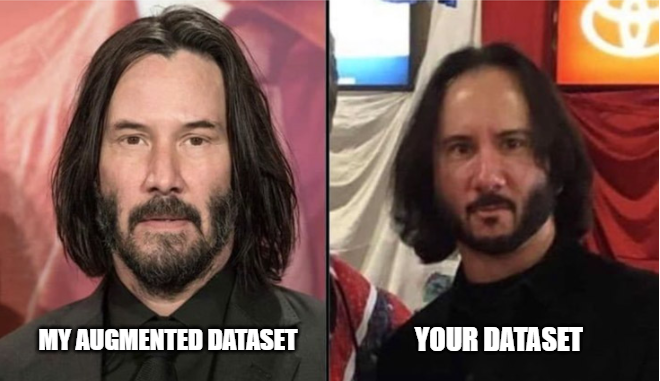

In [ ]:
#NOTE: THE DATASET IS EXTREMELY UNBALANCED!

n_of_label1 = df_text_target[df_text_target.target==1].count().text
n_of_label0 = df_text_target[df_text_target.target==0].count().text
n_tot_label = df_text_target.count().text
number_to_augment = n_of_label0-n_of_label1
print("among all the dataset,only "+str(truncate((n_of_label1/n_tot_label)*100,3))+ "% are diaster-related tweets.")
print("The other "+str(truncate((n_of_label0/n_tot_label)*100,3))+ "% are non disaster related.")
print("We would like to augment the dataset to balance these percentages!")
print("We should introduce "+str(number_to_augment)+" augmented samples with label=1.")

among all the dataset,only 18.592% are diaster-related tweets.
The other 81.407% are non disaster related.
We would like to augment the dataset to balance these percentages!
We should introduce 7142 augmented samples with label=1.


In [ ]:
v = True # enable verbs augmentation. By default is True.
n = True # enable nouns augmentation. By default is False.
runs = 2 # number of times to augment a sentence. By default is 1.
p = 0.5 # The probability of success of an individual trial. (0.1<p<1.0), default is 0.5. Used by Geometric distribution to selects words from a sentence.

#when calling the augmentation on a sample,there will be 50% change that it will be augmented

t = Wordnet(v=v ,n=n, p=p)

#creo un dataframe di #number_to_augment elementi da "augmentare"
df_to_work_with = df_text_target[df_text_target.target==1].sample(abs(number_to_augment),replace=True) 

#creo il dataframe che utilizzerò per il training
df_final = df_text_target.copy()

#appendo come ultime righe del df l'augmentation dei text
for docs in df_to_work_with.iloc:
  df_final.loc[len(df_final)] = [t.augment(docs.text),1]

In [ ]:
print(df_text_target)

print(df_final)

                                                    text  target
0      Communal violence in Bhainsa, Telangana. "Ston...       1
1      Telangana: Section 144 has been imposed in Bha...       1
2      Arsonist sets cars ablaze at dealership https:...       1
3      Arsonist sets cars ablaze at dealership https:...       1
4      "Lord Jesus, your love brings freedom and pard...       0
...                                                  ...     ...
11365  Media should have warned us well in advance. T...       0
11366  i feel directly attacked  i consider moonbin &...       0
11367  i feel directly attacked  i consider moonbin &...       0
11368  ok who remember "outcast" nd the "dora" au?? T...       0
11369     Jake Corway wrecked while running 14th at IRP.       1

[11370 rows x 2 columns]
                                                    text  target
0      Communal violence in Bhainsa, Telangana. "Ston...       1
1      Telangana: Section 144 has been imposed in Bha...       1

#### Salvo il dataframe sul Drive

In [ ]:
with open('/content/drive/My Drive/disasterDataset/df_text_target.csv', 'w') as f:
  df_final.to_csv(f)

#### preprocess data function

STEPS:


*   Normalization
*   stop word and symbols removal
*   stemming
*   lemmatazing





In [ ]:
def preprocess_text(text):
    stemmer = nltk.stem.snowball.SnowballStemmer('english')
    stop_words = stopwords.words('english')
    stop_words.append("https")
    stop_words.append("'s")
    stop_words.append("n't")
    lemmatizer = WordNetLemmatizer()


    text = text.lower()
    tokenized_text = word_tokenize(text,language='english') 

    #stop word and symbols removal
    filtered_text = [] 
    for w in tokenized_text:
        if (w not in stop_words and w.isalnum()): 
            filtered_text.append(w) 
        # if (w not in stop_words and w not in symbol_to_remove): 
        #     filtered_text.append(w) 

    #stemming
    stemmed_sentence=[]
    for elem in filtered_text:
      stemmed_sentence.append(stemmer.stem(elem))

    #lemmatizing
    preprocessed_text = []
    for elem in stemmed_sentence:
      preprocessed_text.append(lemmatizer.lemmatize(elem))

    return preprocessed_text


# **MISCELLANEOUS**

#### leggo il nuovo dataset da drive 

In [ ]:
DIR1 = '/content/drive/My Drive/disasterDataset/df_text_target.csv' #insert your dir path in your google drive

In [ ]:
TEXT = data.Field(tokenize=preprocess_text, batch_first=True, include_lengths = True) #used to preprocess the text field
#TEXT = data.Field(tokenize='spacy', batch_first=True, include_lengths = True) 
                                                                                       #batch_first true measn that when data are returns the first dimension saw will be the batch dimension

LABEL = data.LabelField(dtype =torch.float , batch_first= True )

field = [(None, None), ("text", TEXT), ("label",LABEL)]

training_data = data.TabularDataset(path = DIR1, format = "csv", fields = field, skip_header=True)

#### rimuovo eventuali elementi vuoti

In [ ]:
print(vars(training_data.examples[1000]))
#print(type(vars(training_data.examples[0]))) #dictionary

counter=0
for i,elem in enumerate(training_data.examples):
  if( len(vars(training_data.examples[i])['text'])==0 ): 
    print("the tweet n° "+str(i)+" is empty! let's remove it!")
    counter+=1 #texts with zero length
    del training_data.examples[i] 


print("removed "+str(counter)+" empty docs")

{'text': ['ngl', 'nagrikta', 'ke', 'bill', 'se', 'chanchal', 'banjara', 'insan', 'song', 'perform', 'wed', 'post'], 'label': '0'}
the tweet n° 337 is empty! let's remove it!
the tweet n° 1499 is empty! let's remove it!
the tweet n° 1545 is empty! let's remove it!
the tweet n° 5454 is empty! let's remove it!
the tweet n° 8025 is empty! let's remove it!
the tweet n° 9003 is empty! let's remove it!
the tweet n° 10856 is empty! let's remove it!
removed 7 empty docs


#### random split

In [ ]:
import random

train_data, valid_data = training_data.split(split_ratio = 0.7)

#### costruisco un vocabolario dai nostri train data

In [ ]:
TEXT.build_vocab(train_data, min_freq = 2, vectors = "glove.6B.300d")


In [ ]:
LABEL.build_vocab(train_data)

print("Size of TEXT vocabulary:", len(TEXT.vocab))
print("Size of LABEL vocabulary:", len(LABEL.vocab))

print(TEXT.vocab.freqs.most_common(10))

print(TEXT.vocab.stoi)

#### attivo la GPU e creo train e validation iterators

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 256

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data,valid_data),
    batch_size = BATCH_SIZE,
    sort_key= lambda x: len(x.text),
    sort_within_batch = True,
    device = device)

# **COSTRUZIONE RETE LSTM**

#### Costruisco il classificatore

In [ ]:
import torch.nn as nn

class classifier(nn.Module):

  def __init__(self,vocab_size,embedding_dim,hidden_dim,output_dim, n_layers, bidirectional, dropout):

    super().__init__()

    #first layer: embedding layers. First we create an embed of the word

    self.embedding = nn.Embedding(vocab_size,embedding_dim)

    self.lstm = nn.LSTM(embedding_dim,
                        hidden_dim,
                        n_layers,
                        dropout=dropout,
                        batch_first = True,
                        bidirectional=bidirectional
                        )
    #with bidirectional we are taking infos not only from a word and the next one,but also from a workd and the previous one. So the dimension of the output of lstm will be doubled.


    self.fc = nn.Linear(hidden_dim*2, output_dim)

    self.act = nn.Sigmoid()


  def forward(self,text,text_lengths):

    embedding = self.embedding(text)

    #here we are avoiding to keep in memory the padding element because they do not 
    #carry any useful information!
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedding,text_lengths,batch_first=True)
    #basically our network will work and keep in memory in order to learn as if it wasnt padded
    #thanks to this packed_padded_sequence function

    packed_out, (hidden,cell) = self.lstm(packed_embedded)  #this is the *real* output for the LSTM network


    #in the hidden state there's all the hidden information that the lstm learnt during the process
    
    hidden = torch.cat((hidden[-2,:,:],hidden[-1,:,:]),dim = 1)

    dense_output = self.fc(hidden)
    outputs = self.act(dense_output)
    return outputs



#### inizializzo il classificatore

In [ ]:
size_of_vocab = len(TEXT.vocab)
embedding_dim = 300   #100 is because the glove embedding use 100
num_hidden_nodes = 15
num_output_nodes = 1
num_layers = 5
bidirection = True
dropout = 0.3

print(size_of_vocab)
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes,num_layers,bidirection,dropout)

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings) # we have intiialized our embedding layers manually

print(pretrained_embeddings.shape)

torch.Size([2364, 300])


#### inizializzo l'optimizer,il criterion, e l'accuracy

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(),lr=0.00007,amsgrad=False)

criterion = nn.BCELoss()

def binary_accuracy(preds,y):
  rounded_preds = torch.round(preds)

  correct = (rounded_preds==y).float()
  acc = correct.sum()/len(correct) #manual way to compute accuracy
  return acc

#### passo il modello alla gpu

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

#### train function

In [ ]:
def train(model, iterator, optimizer,criterion):
  epoch_loss = 0
  epoch_acc = 0

  model.train()
  for batch in iterator:
    optimizer.zero_grad()

    text,text_lengths = batch.text

    prediction = model(text, text_lengths.cpu()).squeeze() #we want 1d array

    loss = criterion(prediction,batch.label)

    acc = binary_accuracy(prediction,batch.label)

    loss.backward()

    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

#### evaluation function

In [ ]:
def evaluation(model, iterator, criterion):
  epoch_loss = 0
  epoch_acc = 0

  model.eval()

  with torch.no_grad():
    
    for batch in iterator:
      text,text_lengths = batch.text
      prediction = model(text, text_lengths.cpu()).squeeze() #we want 1d array

      loss = criterion(prediction,batch.label)

      acc = binary_accuracy(prediction,batch.label)
      epoch_loss += loss.item()
      epoch_acc += acc.item()

    return epoch_loss/len(iterator), epoch_acc/len(iterator)

# **TRAINING CLASSIFICATORE**


##Best Result:
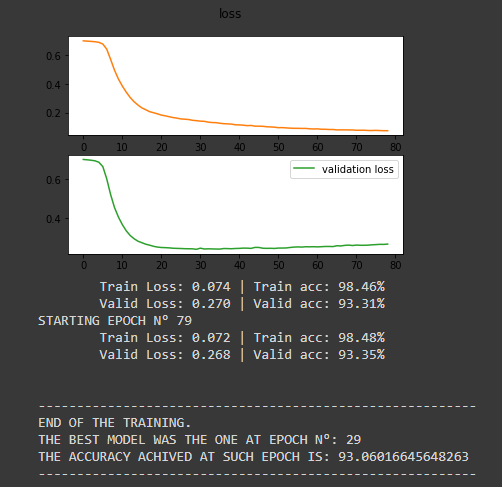

obtained with lr = 0.00007, <h5>
Amsgrad=False <h5>
batch_size= 256 <h5>
min_freq to insert a token into the dictionary=2 ( previously was 5, it scored 91%acc. The first attempt was with 10, it scored 89%)

In [ ]:
N_EPOCH = 60
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
epochs_list = []

best_valid_loss = float("inf")

for epoch in range(N_EPOCH):
  print("STARTING EPOCH N° "+str(epoch))
  train_loss, train_acc = train(model, train_iterator,optimizer=optimizer, criterion=criterion)
  train_loss_list.append(train_loss)
  train_acc_list.append(train_acc)
  epochs_list.append(epoch)

  valid_loss, valid_acc = evaluation(model,valid_iterator, criterion)
  val_loss_list.append(valid_loss)
  val_acc_list.append(valid_acc)

  if valid_loss<best_valid_loss:
    best_valid_loss = valid_loss
    best_acc = valid_acc
    torch.save(model.state_dict(), "saved_weights.pt")
    print("best model at epoch:"+str(epoch))
    best_epoch = epoch
  if epoch%2==0:
    fig, axs = plt.subplots(2)
    fig.suptitle('loss')
    axs[0].plot(epochs_list, train_loss_list,'C1', label = "train loss")
    #plt.legend()
    axs[1].plot(epochs_list, val_loss_list, 'C2', label = "validation loss")
    plt.legend()
    plt.show()


  print(f"\tTrain Loss: {train_loss:.3f} | Train acc: {train_acc*100:.2f}%")
  print(f"\tValid Loss: {valid_loss:.3f} | Valid acc: {valid_acc*100:.2f}%")
print(" ")
print(" ")
print("---------------------------------------------------------")
print("END OF THE TRAINING.")
print("THE BEST MODEL WAS THE ONE AT EPOCH N°: "+str(best_epoch))
print("THE ACCURACY ACHIVED AT SUCH EPOCH IS: "+str(best_acc*100))
print("---------------------------------------------------------")

# **BERT**

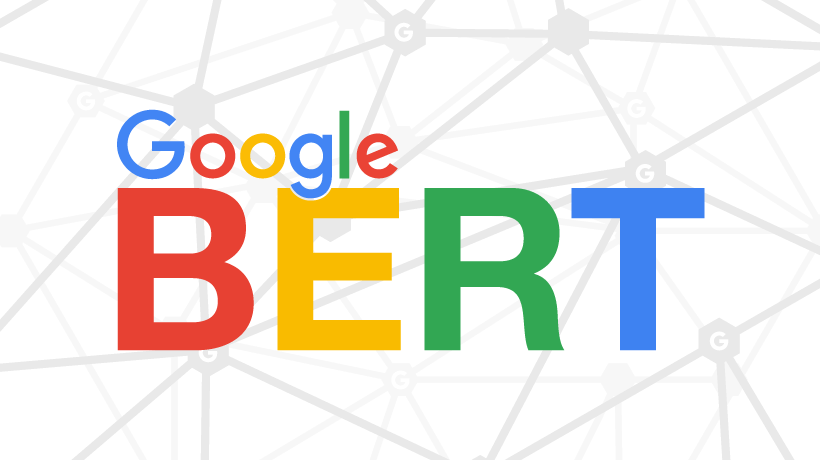

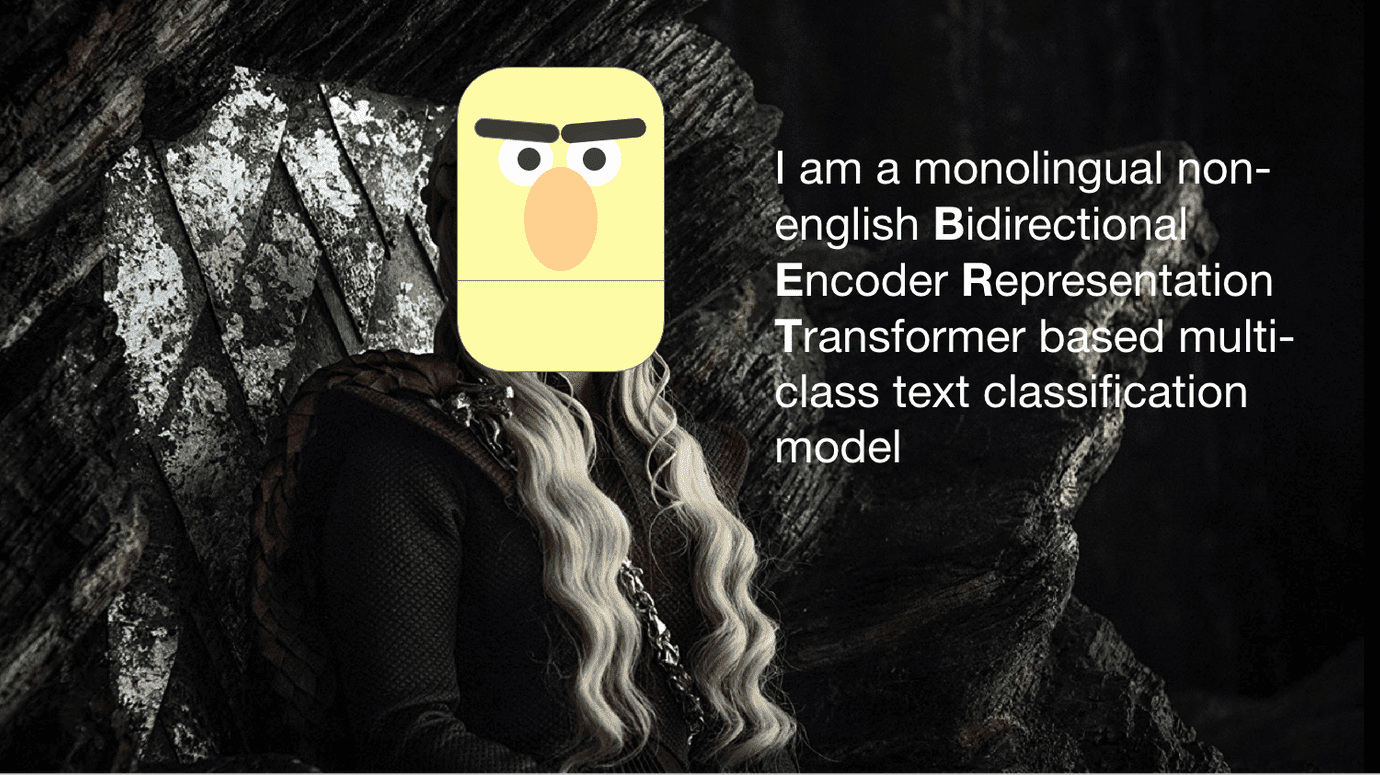

In [ ]:
BERT_MODEL = "bert-base-uncased"
!pip install transformers==3.5


In [ ]:
drive.mount('/content/drive')
DIR = '/content/drive/My Drive/disasterDataset/df_text_target.csv' #insert your dir path in your google drive
df_final = pd.read_csv(DIR)

In [ ]:
from transformers.tokenization_bert import BertTokenizer

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

In [ ]:
texts = df_final['text'].tolist()
labels = df_final['target'].tolist()

target_names = list(set(labels))
label2idx = {label: idx for idx, label in enumerate(target_names)}
print(label2idx)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from transformers.modeling_bert import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels = len(label2idx))
model.to(device)

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.3)
#train_texts, dev_texts, train_labels, dev_labels = train_test_split(rest_texts, rest_labels, test_size=0.1, random_state=1)

print("Train size:", len(train_texts))
print("validation size:", len(val_texts))


Train size: 12958
validation size: 5554


In [ ]:
import logging
import numpy as np

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

MAX_SEQ_LENGTH=150

class BertInputItem(object):
    """An item with all the necessary attributes for finetuning BERT."""

    def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
        self.text = text
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        

def convert_examples_to_inputs(example_texts, example_labels, label2idx, max_seq_length, tokenizer, verbose=0):
    """Loads a data file into a list of `InputBatch`s."""
    
    input_items = []
    examples = zip(example_texts, example_labels)
    for (ex_index, (text, label)) in enumerate(examples):

        # Create a list of token ids
        input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
        if len(input_ids) > max_seq_length:
            input_ids = input_ids[:max_seq_length]

        # All our tokens are in the first input segment (id 0).
        segment_ids = [0] * len(input_ids)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label2idx[label]

        input_items.append(
            BertInputItem(text=text,
                          input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids,
                          label_id=label_id))

        
    return input_items

train_features = convert_examples_to_inputs(train_texts, train_labels, label2idx, MAX_SEQ_LENGTH, tokenizer, verbose=0)
val_features = convert_examples_to_inputs(val_texts, val_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)
#test_features = convert_examples_to_inputs(test_texts, test_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)

In [ ]:
print(train_features)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

def get_data_loader(features, max_seq_length, batch_size, shuffle=True): 

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    return dataloader

BATCH_SIZE = 64

train_dataloader = get_data_loader(train_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)
val_dataloader = get_data_loader(val_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
#test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)

In [ ]:
def evaluate(model, dataloader):
    model.eval()
    
    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            tmp_eval_loss, logits = model(input_ids, attention_mask=input_mask,
                                          token_type_ids=segment_ids, labels=label_ids)

        outputs = np.argmax(logits.to('cpu'), axis=1)
        label_ids = label_ids.to('cpu').numpy()
        
        predicted_labels += list(outputs)
        correct_labels += list(label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    
    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)
        
    return eval_loss, correct_labels, predicted_labels

In [ ]:
from transformers.optimization import AdamW
from transformers import get_linear_schedule_with_warmup

GRADIENT_ACCUMULATION_STEPS = 1
NUM_TRAIN_EPOCHS = 20
LEARNING_RATE = 5e-5
lr=0.0001
WARMUP_PROPORTION = 0.1
MAX_GRAD_NORM = 5

num_train_steps = int(len(train_dataloader.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

optimizer = AdamW(optimizer_grouped_parameters, lr=lr, correct_bias=False)
#scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_train_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps = num_train_steps)


In [ ]:
import torch
import os
from tqdm import trange
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix

OUTPUT_DIR = "/tmp/"
MODEL_FILE_NAME = "pytorch_model.bin"
PATIENCE = 2

loss_history = []
no_improvement = 0
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
        loss = outputs[0]

        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        tr_loss += loss.item()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)  
            
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            
    val_loss, _, _ = evaluate(model, val_dataloader)
    
    print("Loss history:", loss_history)
    print("Dev loss:", val_loss)
    
    if len(loss_history) == 0 or val_loss < min(loss_history):
        no_improvement = 0
        model_to_save = model.module if hasattr(model, 'module') else model
        output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
    else:
        no_improvement += 1
    
    if no_improvement >= PATIENCE: 
        print("No improvement on development set. Finish training.")
        break
        
    
    loss_history.append(val_loss)

In [ ]:
n_epoch = len(loss_history)
epochs_list=[]
for i in range(n_epoch):
  epochs_list.append(i+1)
plt.plot(epochs_list, loss_history, 'C2', label = "validation loss")
plt.legend()
plt.show()

In [ ]:
model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc: storage)
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, state_dict=model_state_dict, num_labels = len(target_names))
model.to(device)

model.eval()

_, train_correct, train_predicted = evaluate(model, train_dataloader)
_, val_correct, val_predicted = evaluate(model, val_dataloader)

bert_accuracy = np.mean(val_predicted == val_correct)

precision, recall, fscore, support = precision_recall_fscore_support(val_correct, val_predicted)
print("-----BERT performance summary-----")
print("")
print("overall accuracy: {}".format(bert_accuracy))
print("")
print('precision on first label: {}'.format(precision[0]))
print('precision on second label: {}'.format(precision[1]))
print("")
print('recall on first label: {}'.format(recall[0]))
print('recall on second label: {}'.format(recall[1]))
print("")
print('fscore on first label: {}'.format(fscore[0]))
print('fscore on second label: {}'.format(fscore[1]))
print("")
print('support on first label: {}'.format(support[0]))
print('support on second label: {}'.format(support[1]))

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
label = np.array([0,1])

cm = confusion_matrix(val_correct, val_predicted,labels=label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label)
disp.plot() 

In [ ]:

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
best_acc = 0.907

print("BERT accuracy: "+str(bert_accuracy*100))
print("basic classifier accuracy: "+str(best_acc*100))

df = pd.DataFrame({"accuracy": {"basic": best_acc, "BERT": bert_accuracy}})
plt.rcParams['figure.figsize'] = (7,4)
df.plot(kind="bar")